# **Dados sintéticos**

In [3]:
!pip install tqdm


Installing packages through the IPython console doesn't work reliably in Spyder. Please use a system terminal to do that, i.e. cmd.exe on Windows, Terminal on macOS or xterm on Linux.


--- FASE 1: Gerador V20 (PI=60-65k, Rampa Suave) ---


100%|██████████| 20000/20000 [00:01<00:00, 12625.55it/s]


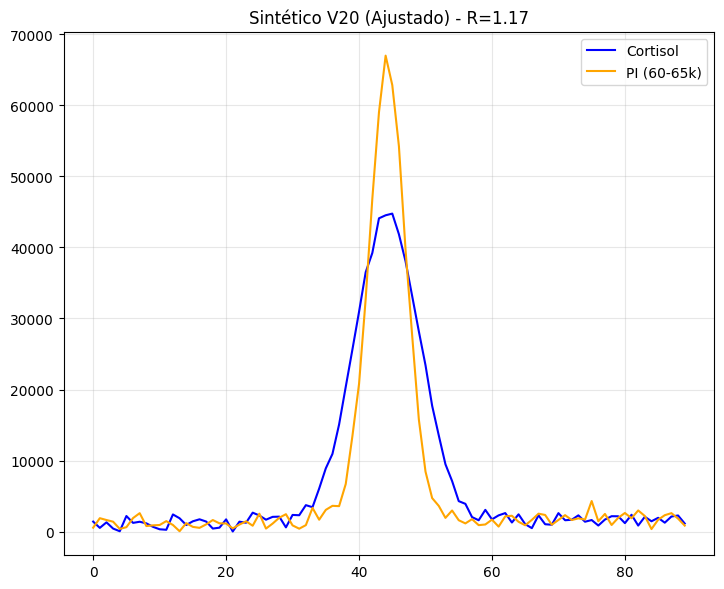

(20000, 90, 4)


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

# --- CONFIGURAÇÃO ---
caminho_base = ''
caminho_dados_cv = os.path.join(caminho_base, 'dados_finais_cv/')
caminho_sintetico = os.path.join(caminho_base, 'dados_sinteticos_v20/') # Pasta V20
os.makedirs(caminho_sintetico, exist_ok=True)

# Janela Sniper (350-440)
WINDOW_SIZE = 90

print(f"--- FASE 1: Gerador V20 (PI=60-65k, Rampa Suave) ---")

def gerar_pico_gaussiano(x, amplitude, centro, largura):
    return amplitude * np.exp(-((x - centro) ** 2) / (2 * largura ** 2))

X_v20 = []
y_v20 = []
x_axis = np.arange(WINDOW_SIZE)

for _ in tqdm(range(20000)):
    sinal = np.zeros((WINDOW_SIZE, 4))

    # A. Fundo com Rampa SUAVE
    altura_rampa = np.random.uniform(500, 2000)
    rampa = np.linspace(0, altura_rampa, WINDOW_SIZE)

    for c in range(4):
        ruido = np.random.normal(0, 800, WINDOW_SIZE)
        # Offset base (~1000) + Rampa Suave + Ruído
        sinal[:, c] = np.abs(ruido + rampa + 1000)

    # B. Picos
    centro = np.random.uniform(35, 55)
    largura_c = np.random.uniform(3.0, 5.0)
    largura_p = np.random.uniform(2.5, 4.0)

    # PI:
    altura_p = np.random.normal(62500, 2500)

    # Cortisol: Razão 0 a 20
    ratio = np.random.uniform(0.0, 20.0)
    altura_c = altura_p * ratio

    pico_c = gerar_pico_gaussiano(x_axis, altura_c, centro, largura_c)
    pico_p = gerar_pico_gaussiano(x_axis, altura_p, centro, largura_p)

    sinal[:, 1] += pico_c
    sinal[:, 3] += pico_p

    # Rótulo
    area_c = np.sum(pico_c)
    area_p = np.sum(pico_p)

    X_v20.append(sinal)
    y_v20.append(area_c / (area_p + 1e-9))

X_v20 = np.stack(X_v20)
y_v20 = np.array(y_v20)

# Salvar V20
np.save(os.path.join(caminho_sintetico, 'X_train_synth_v20.npy'), X_v20)
np.save(os.path.join(caminho_sintetico, 'y_train_synth_v20.npy'), y_v20)

# --- VISUALIZAÇÃO COMPARATIVA ---
# Carregar um real para comparar
try:
    X_real_smooth = np.load(os.path.join(caminho_dados_cv, 'X_all_smooth.npy'))
    tem_real = True
except:
    tem_real = False

plt.figure(figsize=(14, 6))

# Plot Sintético V20
plt.subplot(1, 2, 1)
# Pega um exemplo com razão baixa (~1.0) para ver bem o PI
indices_medios = np.where((y_v20 > 0.8) & (y_v20 < 1.2))[0]
idx = indices_medios[0] if len(indices_medios) > 0 else 0

plt.plot(X_v20[idx, :, 1], label='Cortisol', color='blue')
plt.plot(X_v20[idx, :, 3], label='PI (60-65k)', color='orange')
plt.title(f"Sintético V20 (Ajustado) - R={y_v20[idx]:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Real Suavizado
if tem_real:
    plt.subplot(1, 2, 2)
    plt.plot(X_real_smooth[0, :, 1], label='Cortisol Real', color='black')
    plt.plot(X_real_smooth[0, :, 3], label='PI Real', color='red')
    plt.title("Real Suavizado (Referência)")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(X_v20.shape)

In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, Add, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

caminho_base = ''
caminho_sintetico = os.path.join(caminho_base, 'dados_sinteticos_v20/') # V20
caminho_dados_cv = os.path.join(caminho_base, 'dados_finais_cv/')
caminho_modelo_v20 = os.path.join(caminho_base, 'modelo_resnet_v20.keras')

print("--- FASE 1: Pre-Training V20 ---")
X_synth = np.load(os.path.join(caminho_sintetico, 'X_train_synth_v20.npy'))
y_synth = np.load(os.path.join(caminho_sintetico, 'y_train_synth_v20.npy'))

# Normalização
mean_v20 = np.mean(X_synth)
std_v20 = np.std(X_synth)
X_synth_norm = (X_synth - mean_v20) / (std_v20 + 1e-9)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_synth_norm, y_synth, test_size=0.2)

# Arquitetura ResNet
def build_resnet(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 5, padding='same')(inputs); x = BatchNormalization()(x); x = Activation('relu')(x)

    res = x
    x = Conv1D(32, 3, padding='same')(x); x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(32, 3, padding='same')(x); x = BatchNormalization()(x); x = Add()([x, res]); x = Activation('relu')(x)

    res = Conv1D(64, 1, strides=2)(x)
    x = Conv1D(64, 3, strides=2, padding='same')(x); x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(64, 3, padding='same')(x); x = BatchNormalization()(x); x = Add()([x, res]); x = Activation('relu')(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x); x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

model = build_resnet((90, 4))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_s, y_train_s, validation_data=(X_val_s, y_val_s), epochs=30, batch_size=64, verbose=0)
model.save(caminho_modelo_v20)
print(f"Pre-Treino R²: {r2_score(y_val_s, model.predict(X_val_s, verbose=0)):.4f}")

print("\n--- FASE 2: Transfer Learning (Real Suavizado) ---")
# Carregar Real SUAVIZADO
X_real_smooth = np.load(os.path.join(caminho_dados_cv, 'X_all_smooth.npy'))
y_real_razao = np.load(os.path.join(caminho_dados_cv, 'y_razao_all.npy'))
groups_all = np.load(os.path.join(caminho_dados_cv, 'groups_all.npy'))

# Normaliza com stats do V20
X_real_norm = (X_real_smooth - mean_v20) / (std_v20 + 1e-9)

gkf = GroupKFold(n_splits=5)
y_pred_total = np.zeros_like(y_real_razao)
y_true_total = np.zeros_like(y_real_razao)

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_real_norm, y_real_razao, groups_all)):
    model_fold = load_model(caminho_modelo_v20)
    model_fold.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mse')

    model_fold.fit(X_real_norm[train_idx], y_real_razao[train_idx], epochs=40, batch_size=8, verbose=0)
    pred = model_fold.predict(X_real_norm[test_idx], verbose=0).flatten()
    y_pred_total[test_idx] = pred
    y_true_total[test_idx] = y_real_razao[test_idx]
    print(f"Fold {fold+1}: R² = {r2_score(y_real_razao[test_idx], pred):.4f}")

r2_final = r2_score(y_true_total, y_pred_total)
print(f"\nRESULTADO FINAL V20: R² Global = {r2_final:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true_total, y_pred_total, alpha=0.7, color='brown')
plt.plot([min(y_true_total), max(y_true_total)], [min(y_true_total), max(y_true_total)], '--r')
plt.title(f"ResNet V20 (Ajustado) - R²: {r2_final:.4f}")
plt.xlabel("Razão Real")
plt.ylabel("Razão Prevista")
plt.grid(True)
plt.show()

--- FASE 1: Pre-Training V20 ---
Pre-Treino R²: 0.9880

--- FASE 2: Transfer Learning (Real Suavizado) ---


FileNotFoundError: [Errno 2] No such file or directory: 'dados_finais_cv/X_all_smooth.npy'